### Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
from scipy import stats

### Load data files

In [3]:
filename_BCTD = 'C1_DATA_20250723.csv'
df_bctd = pd.read_csv(filename_BCTD, na_values=-999, dtype={"CRUISE": str})

### Subset by data, station, and depth

In [5]:
df_bctd = df_bctd[~df_bctd['TMP'].isna()]
df18 = df_bctd
df18['Date'] = pd.to_datetime(df18['DATE_TIME'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
df18 = df18[(df18['Date'].dt.year >= 2008) & (df18['Date'].dt.year <= 2023)]
df18 = df18.sort_values('Date', ascending=True)
df18['month'] = df18['Date'].dt.month
df18['Year'] = df18['Date'].dt.year
df18 = df18[df18['CTRB_ID'].isin(['C1', 'c1'])]
df18 = df18[df18['DEPTH'] <=10 ]

### Compute and plot anomaly

In [6]:
df18['Date'] = pd.to_datetime(df18['Date'])
df18 = df18.set_index('Date')

def compute_anomaly(df, var, window=7):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_daily = df[numeric_cols].resample('D').mean()
    df_daily[var] = df_daily[var].interpolate(method='time')
    df_daily['doy'] = df_daily.index.dayofyear
    climatology = df_daily.groupby('doy')[var].mean()
    df_daily['climatology'] = df_daily['doy'].map(climatology)
    df_daily['anomaly'] = df_daily[var] - df_daily['climatology']
    df_daily['anomaly_smoothed'] = (
        df_daily['anomaly']
        .rolling(window=window, center=True, min_periods=1)
        .mean()
    )
    return df_daily.reset_index()

vars_to_plot = ['SIO4', 'NO3', 'PO4', 'TMP']
window_size = 5

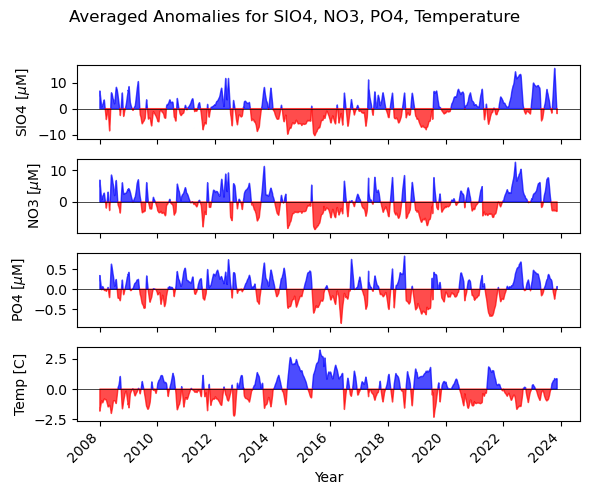

In [8]:
fig, axes = plt.subplots(len(vars_to_plot), 1, figsize=(6, 5), sharex=True)
for i, var in enumerate(vars_to_plot):
    df_anom = compute_anomaly(df18, var, window=window_size)
    axes[i].fill_between(df_anom['Date'], 0, df_anom['anomaly_smoothed'],
                         where=df_anom['anomaly_smoothed'] > 0, color='blue', alpha=0.7)
    axes[i].fill_between(df_anom['Date'], 0, df_anom['anomaly_smoothed'],
                         where=df_anom['anomaly_smoothed'] < 0, color='red', alpha=0.7)
    axes[i].axhline(0, color='black', linewidth=.5)

axes[0].set_ylabel(f'SIO4 [$\\mu$M]')
axes[1].set_ylabel(f'NO3 [$\\mu$M]')
axes[2].set_ylabel(f'PO4 [$\\mu$M]')
axes[3].set_ylabel(f'Temp [C]')

axes[-1].set_xlabel('Year')
plt.suptitle(f'Averaged Anomalies for SIO4, NO3, PO4, Temperature', fontsize=12)
plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("Seasonal_images/C1_Parameters_w11.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot averages

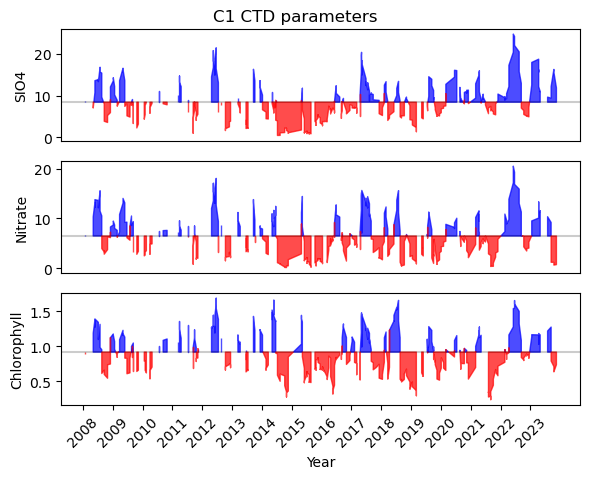

In [371]:
x = df18['Date'] 
z = df18['SIO4']
z2 = df18['NO3']
z3 = df18['CHLA']

z_avg = z.mean()
z_avg2 = z2.mean()
z_avg3 = z3.mean()

z = z.rolling(window=5, center=True).mean()
z2 = z2.rolling(window=5, center=True).mean()
z3 = z3.rolling(window=5, center=True).mean()

plt.figure(figsize=(6, 5))
plt.suptitle('C1 CTD parameters', fontsize=12, y=0.95)

plt.subplot(3, 1, 1)
plt.fill_between(x, z_avg, z, where=(z > z_avg), interpolate=True, color='blue', alpha=0.7)
plt.fill_between(x, z, z_avg, where=(z < z_avg), interpolate=True, color='red', alpha=0.7)
plt.axhline(z_avg, color='black', linestyle='-', alpha=0.2)
plt.ylabel('SIO4')
plt.gca().set_xticks([])

plt.subplot(3, 1, 2)
plt.fill_between(x, z_avg2, z2, where=(z2 > z_avg2), interpolate=True, color='blue', alpha=0.7)
plt.fill_between(x, z2, z_avg2, where=(z2 < z_avg2), interpolate=True, color='red', alpha=0.7)
plt.axhline(z_avg2, color='black', linestyle='-', alpha=0.2)
plt.ylabel('Nitrate')
plt.gca().set_xticks([])

ax3 = plt.subplot(3, 1, 3)
plt.fill_between(x, z_avg3, z3, where=(z3 > z_avg3), interpolate=True, color='blue', alpha=0.7)
plt.fill_between(x, z3, z_avg3, where=(z3 < z_avg3), interpolate=True, color='red', alpha=0.7)
plt.axhline(z_avg3, color='black', linestyle='-', alpha=0.2)
plt.ylabel('Chlorophyll')
plt.gca().set_xticks([])

years = sorted(df18['Date'].dt.year.unique())
tick_positions = [pd.Timestamp(f"{year}-01-01") for year in years]
ax3.set_xticks(tick_positions)
ax3.set_xticklabels([str(year) for year in years], rotation=45)

plt.xlabel('Year')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.2)
plt.tight_layout()
#plt.savefig("Seasonal_images/C1_Parameters_w10.png", dpi=300, bbox_inches='tight')
plt.show()